# Twitter Sentiment Analysis - POC
---

## Tfidf with single trees

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd
import scipy.sparse as sp

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Load $m\approx250k$, $n=50k$ training subset

In [2]:
# processed dir
proc_dir = os.path.join("..","data","3_processed","sentiment140")
X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_Tfidf_250k_50k.npz"))
with open(os.path.join(proc_dir, "y_array_250k.npy"), 'rb') as f:
    y_array = np.load(f)

In [3]:
# sanity check
X_train_transformed, len(y_array)

(<251468x50001 sparse matrix of type '<class 'numpy.float64'>'
 	with 2569112 stored elements in Compressed Sparse Row format>,
 251468)

### Decision Trees


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_train_transformed, 
                                                    y_array, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [5]:
# get notion of max depth's theoretical limit
print(f'Approx. tree depth without restrictions: {np.ceil(np.log2(X_train.shape[0])):0.0f}')

Approx. tree depth without restrictions: 18


Conducting some basic hyperparameter tuning, I'll restrict tree depths indirecly via the args `max_leaf_nodes` and `min_samples_split` from Scikit-Learn's **DecisionTreeClassifier** [(source)](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/tree/_classes.py#L597) using **GridSearchCV** [(source)](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/model_selection/_search.py#L867) - just as in the POC [study notebook.](10.extra_GrowingRandomForests.ipynb)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [8]:
params = {'max_leaf_nodes': 99, 'min_samples_split': 2}

In [14]:
# accuracy for a single tree
tree = DecisionTreeClassifier(max_leaf_nodes=99, min_samples_split=2, random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
accuracy_score(y_test, y_pred)

0.6902811468564839

In [15]:
# cross validation on entire training data for a more robust result
scores = cross_val_score(tree, X_train_transformed, y_array, cv=5, verbose=1, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 0.6889 (+/- 0.00)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min finished


One worry with decision trees is overfitting the training data - and even with this lower accuracy for a single tree, we should check how it is learning. We can do this by plotting learning curves, feeding rows and plotting the training vs validation accuracy at different data volumes to see whether the validation accuracy is increasing and training accuracy getting more realistic (decreasing). If the learning curve is smoothly going down, feeding more data could improve accuracy.

In [16]:
import matplotlib.pyplot as plt

def plot_learning_curves_feed_m(model, X, y, Xname):
    """Plot the learning curves for train and validation sets
       , by adding more rows (m) and keeping the number of 
       features (n) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    # train
    # change data granularity (denominator) for more/less data points
    data_granularity = int(X_train.shape[0]/8)
    xs, train_acc, valid_acc = [], [], []
    for m in range(10, X_train.shape[0], data_granularity):       
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_valid_predict = model.predict(X_valid)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, 
                       # dynamically calculate number of x ticks
                       round(X_train.shape[0]/data_granularity, 0), 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

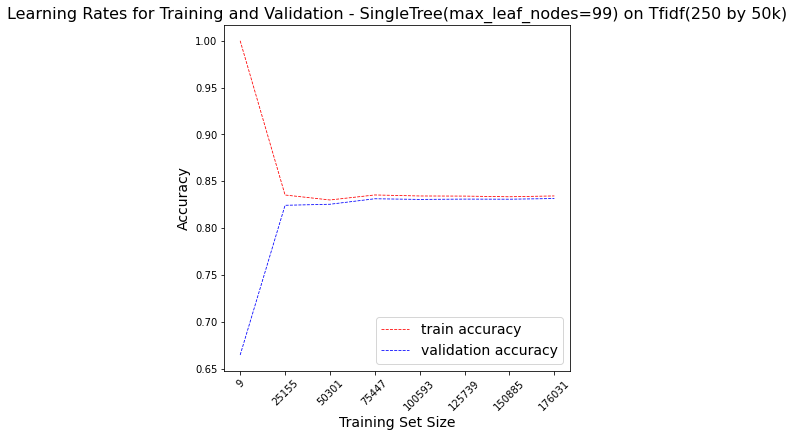

In [17]:
plot_learning_curves_feed_m(tree, X_train_transformed, y_array, 
                           'SingleTree(max_leaf_nodes=99) on Tfidf(250 by 50k)')

The model appears to have converged on its best accuracy after only a fraction of the training data so adding more data will not be helpful. Another parameter we might consider tweaking a bit is `max_features`, since default of **None** means `n_features` and we know we have a lot of features.

In [18]:
params = {'max_features': 11000, 'max_leaf_nodes': 99}

In [19]:
#Max mean test accuracy: 0.6925 

In [20]:
tree_clf = DecisionTreeClassifier(random_state=42, max_leaf_nodes=99, max_features=11000)

# cross validation on entire training data for a more robust result
scores = cross_val_score(tree_clf, X_train_transformed, y_array, cv=5, verbose=1, scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 0.6851 (+/- 0.01)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


### Comparison with BoW 

Results are fairly similar, 0.6832 accuracy with BoW was lower but that might've been due to chance.

---